# 6.5.1 Best Subset Selection

In [70]:
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In this lab we apply the best subset selection approach to the Hitters data. We wish to predict a baseball player’s Salary on the basis of various statistics associated with performance in the previous year.


In [71]:
hitters = pd.read_csv('DataSets/Hitters.csv')
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


Observing the data, we note that the Salary variable is missing for some of the players. The isnull() function
can be used to identify the missing observations. It returns a vector of the same length as the input vector,
with a TRUE value for any elements that are missing, and a FALSE value for non-missing elements. The sum()
function can then be used to count all of the missing elements:

In [72]:
print(hitters["Salary"].isnull().sum())

59


We see that Salary is missing for 59 players. The dropna() function removes all of the rows that have missing values in any variable:

In [73]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print(hitters.shape)


(322, 21)


In [74]:
# Drop any rows the contain missing values, along with the player names
hitters = hitters.dropna()


In [75]:
# Drop the player names
hitters = hitters.drop('Unnamed: 0', axis=1)

In [76]:
# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print(hitters.shape)

(263, 20)


In [77]:
# Should return 0
print(hitters["Salary"].isnull().sum())

0


In [1]:
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
y = hitters.Salary
# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

NameError: name 'pd' is not defined

Best subset selection can be performed by identifying the best model that contains a given number of predictors, where best is quantified using RSS. We need to define a helper function that outputs the best set of variables for each model size:

In [79]:
# This function fits the model on feature_set and calculates RSS
def processSubset(feature_set):
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [80]:
def getBest(k):

    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))

    models = pd.DataFrame(results)
    
    # Choose the model with the smallest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model
    return best_model

This returns a DataFrame containing the best model that we generated, along with some extra information
about the model. Next, we will call that function for each number of predictors k:

In [82]:
models = pd.DataFrame(columns=["RSS", "model"])

for i in range(1,9):
    models.loc[i] = getBest(i)


The DataFrame models contains contains the best models we’ve generated. Let’s take a look at the first few:

In [83]:
models

,RSS,model
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...
5,2.718780e+07,<statsmodels.regression.linear_model.Regressio...
6,2.639772e+07,<statsmodels.regression.linear_model.Regressio...
7,2.606413e+07,<statsmodels.regression.linear_model.Regressio...
8,2.548030e+07,<statsmodels.regression.linear_model.Regressio...


If we want to access the details of each model, we can get a full rundown of a single model
using the summary() function. The summary() function also returns R2, RSS, adjusted R2, Cp, AIC, and BIC.
We can examine these to try to select the best overall model.

In [84]:
print(models.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Mon, 08 May 2017   Prob (F-statistic):           5.80e-82
Time:                        15:56:47   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.0

This output indicates that the best two-variable model contains only Hits and CRBI.

Rather than letting the results of our call to the summary() function print to the screen, we can access
just the parts we need using the model’s attributes. For example, if we want the R2 value:

In [85]:
models.loc[2, "model"].rsquared

0.7614950002332872

In addition to the verbose output we get when we print the summary to the screen, fitting the OLM also produced many other useful statistics such as adjusted R2, AIC, and BIC. We can examine these to try to select the best overall model. Let’s start by looking at R2 across all our models:

In [86]:
# Gets the second element from each row (’model’) and pulls out its rsquared attribute
models.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
8    0.802259
dtype: float64

 As expected, the R2 statistic increases monotonically as more variables are included. We see that the R2 statistic increases from 0.665, when only one variable is included in the model, to almost 0.798, when all variables are included.

Plotting RSS, adjusted R2, Cp, and BIC for all of the models at once will help us decide which model to select. We plot a red dot to indicate the models with the largest adjusted R2 statistic, and smalles AIC, BIC and RSS statistics.

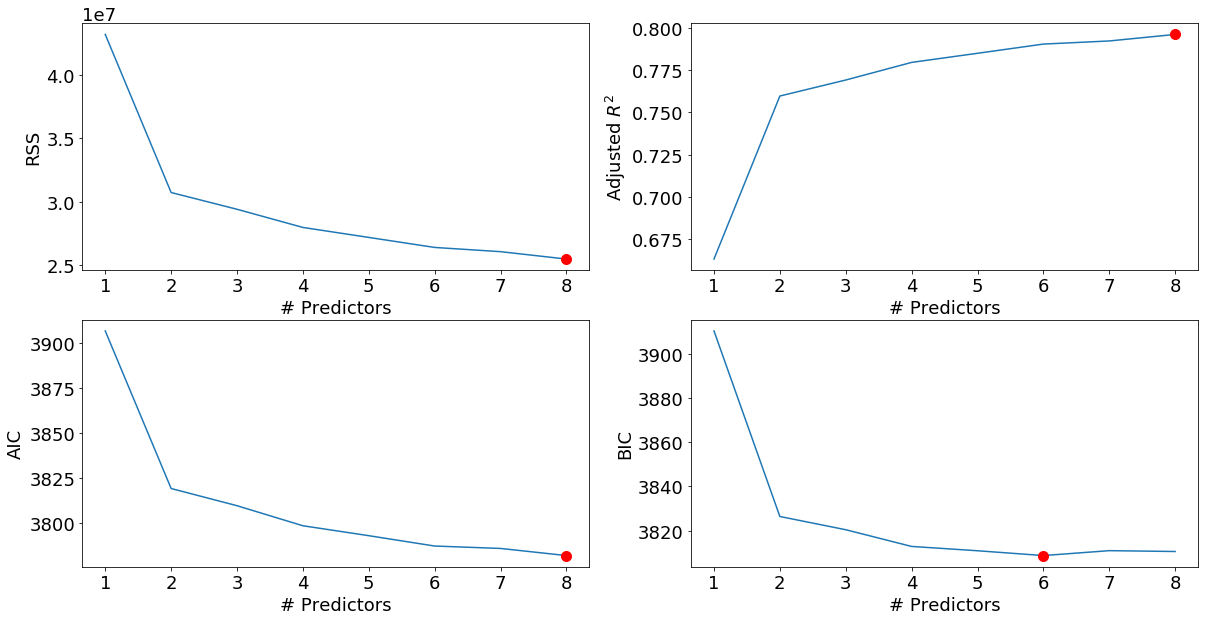

In [87]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)

plt.plot(models["RSS"])
plt.plot(models["RSS"].argmin(), models["RSS"].min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('RSS')


rsquared = models.apply(lambda row: row[1].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared)
plt.plot(rsquared.argmax(), rsquared.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('Adjusted $R^2$')



aic = models.apply(lambda row: row[1].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')



bic = models.apply(lambda row: row[1].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')
plt.title('Best Subset Selection')
plt.savefig('BestSubsetSelection.png', dpi=200)


In the second step of the selection process, we narrowed the field down to just one model on any $k \le p$ predictors. We see that several models share a BIC close to −3820. However, the model with the lowest BIC is the six-variable model that contains only AtBat, Hits, Walks, CRBI, DivisionW, and PutOuts. Therefore, according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted R2 something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture but they all agree that a model with 5 or fewer predictors is insufficient.

In [88]:
print(models.loc[6, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     166.3
Date:                Mon, 08 May 2017   Prob (F-statistic):           1.79e-85
Time:                        15:56:56   Log-Likelihood:                -1887.6
No. Observations:                 263   AIC:                             3787.
Df Residuals:                     257   BIC:                             3809.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
AtBat         -1.5488      0.477     -3.248      0.0